# CRISP DM Framework for data mining
### 1. Business understanding
#### Determine the business objectives
##### Determine the background, business objectives and business success criteria.
Background: Due to the current nature of marketting, potential customers have become desensitized to mass marketting campaigns. With a success rate of less than %1 according to the article provided it is necessary for service or product providers to use targetted marketting campaigns to decrease waste of spending on large marketting campaigns with expected larger success rates for the targetted individuals. For this project a bank would like to decrease the amount of marketting campaigns while still maintaining an approximately same number of individuals who will apply to attractive long term deposits with good interest rates. In simpler terms, the bank would like to increase the efficiency of their targetted marketting campaigns.

#### Asses the situation
##### Inventory of resources
The resources available for this project is the "Bank Marketing" data sets from UC irvine. There are four data sets.
1. data set with 20 inputs, ordered by data.
2. 10 percent subset of the previous data set
3. data set with 17 inputs, ordered by data representing an older data set with less inputs than (1.)
4. 10 percent subset of data set (3)
##### Requirements
Due data: 10/16/23
Comprehensibility: The results should be given as the best model between multiple classification models. For each type of classifier used, the best model must be shown using a suitable metric such as ROC curve or confusion matrix.
##### Terminology.

##### Costs and benefits.
Not applicable
### Produce project plan
##### Project plan

##### Initial assessment of the tools and techniques


### 2. Data understanding



In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

In [2]:
#read the data and display the first 5 rows
df = pd.read_csv(r"C:\Users\User\Desktop\machine_learning_practice_data\module_17\bank-additional\bank-additional\bank-additional-full.csv",delimiter=";")
#print(df.head())
#determine the number of unique entries in each column
print(df.nunique())
print(df.info())

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null

### Understanding of data from initial investigation
From the initial observation of the data and the description of the different features in the attached text file, there are multiple columns that are supposed to be binary but have some missing values. It is also important that for the various numerical categories i observe the form of the data (skew left, skew right etc.) to do this i can display histograms of each of the features and determine the next steps such as which columns to drop and what to do with missing values.


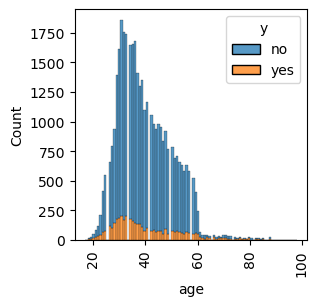

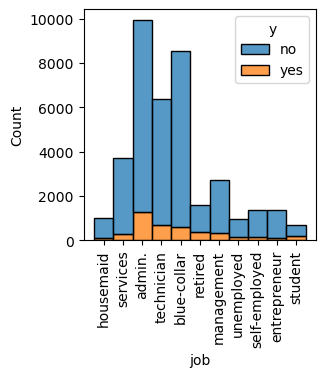

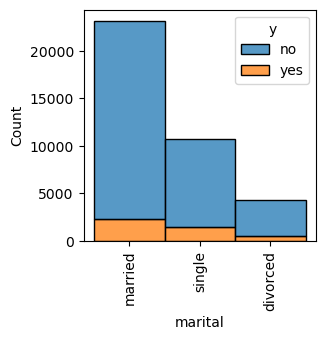

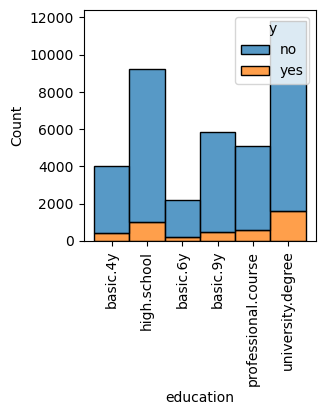

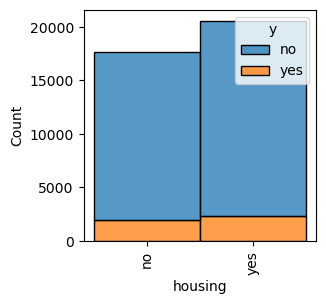

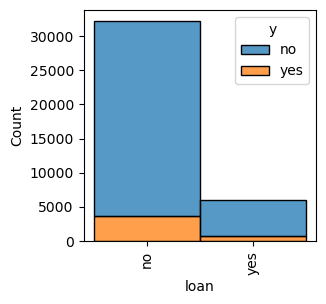

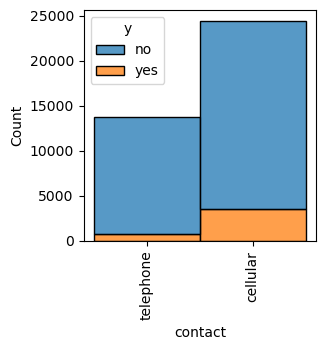

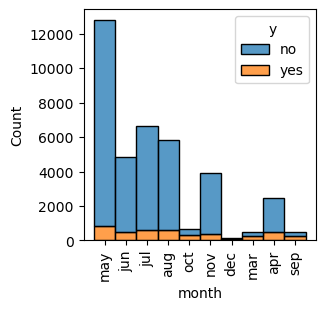

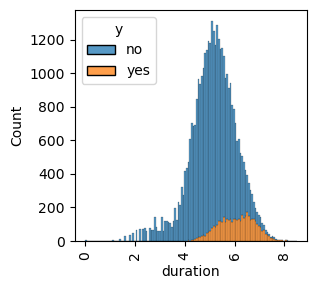

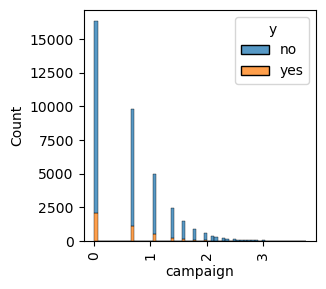

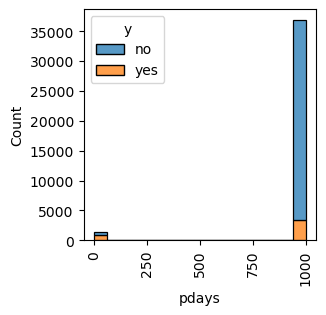

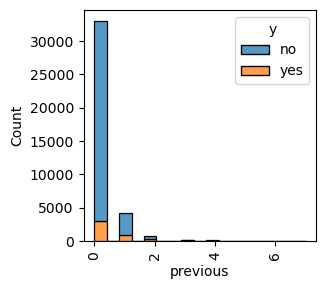

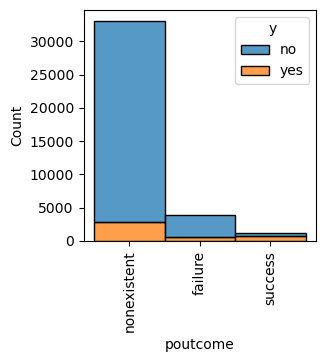

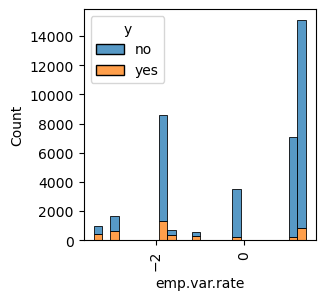

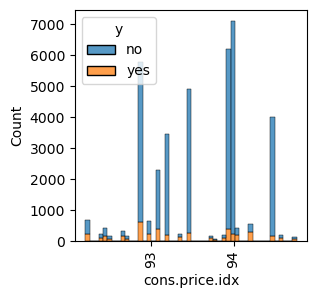

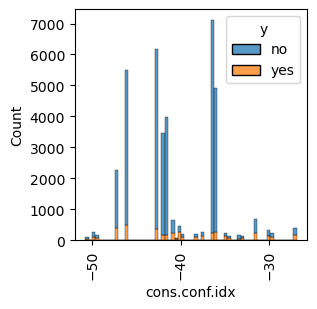

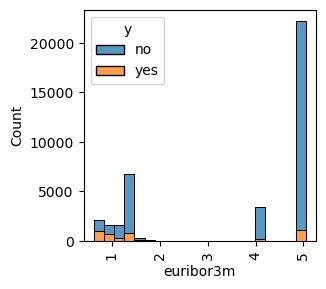

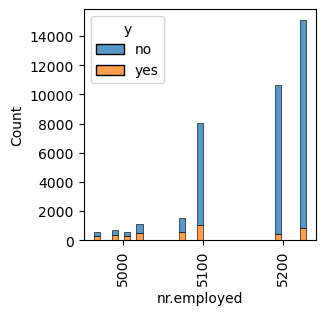

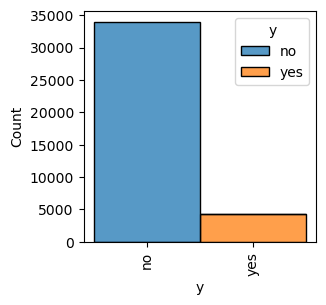

In [49]:
#create bar graphs of each amount of entries for the columns with hue being the y column
for column in df.columns:
    plt.figure(figsize=(3,3))
    sns.histplot(data=df,x=column,hue='y',multiple='stack')
    plt.xticks(rotation=90)
    plt.show()

# Graphical interpretation of the data
### From the histograms produced above the following adjustments seem important:
1. Drop column "default": this is because the number of individuals who defaulted on loans is extremely low and the number of unknow values would be imputed most probably as category "no".
2. Drop columns "day of week": this column is evenly distributed betwen the different days of the week in terms of both overall quantiy as well as positive response. Since this is a categorical feature, removing this column will reduce the dimensionality consoderably for the over-all modelling effort.
3. Dropping "illiterate" values from the "education" feature: this was done as there were so few illiterate values that the training data did not initially contain these and did not hot encode this value for testing the models produced, therefore it was removed.
4. Drop all "unknown" values: This was done instead of using an imputer as both options are feasible and even after this reduction, large sets of the data was maintained.
5. Setting 'duration' feature to drop all values lower than 1: this was necessary since a further logarithmic scaler was required for this feature and could not be applied to values lower than 1 without the fitted models failing due to the nature of log functions.
6. Aplying logarithmic scaling to features "duration" and "campaign": since these data were both positively skewed, applying this change allows for better scaling using standard scaler in later steps.

# 3. Data preperation
From the previous graphical interpretation of the data, the changes were applied to the input data before any further processing.

In [4]:
#remove unnecessary columns: ['default','days_of_week']
df = df.drop(columns=['default','day_of_week'])

#drop the following values:
    #drop illiterate in education column
df = df[df['education']!= 'illiterate']
    #drop unknown in remaining data set
df = df[df.apply(lambda col: col != 'unknown',axis=0).all(axis=1)]
    #drop values = 0 in duration
df = df[df['duration']>=1]
#apply logistic scaler to skew data ['duration','campaign','previous']
columns = ['duration','campaign']
for col in columns:
    df[col] = np.log(df[col])

In [5]:
#create the x and y data as well as the test and train
X = df.drop(columns='y')
y = df['y']

#to keep things simple i mapped the yes and no values for the target column as 1 and 0
X_train, X_test, y_train, y_test = train_test_split(X,y.map({'yes':1,'no':0}),test_size=0.3,stratify=y)

#completing all initial data manipulation its necessary to observe the new data to ensure that the columns were dropped
# and that all binary features only contained two values.
print(df.nunique())

age                 77
job                 11
marital              3
education            6
housing              2
loan                 2
contact              2
month               10
duration          1513
campaign            41
pdays               26
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          314
nr.employed         11
y                    2
dtype: int64


# 4. Modelling
### Selection of techniques:
For this excercise the following models were to be used:
1. KNN classifier
2. Logistic Regression
3. Decision Tree Classifier
4. Support Vector Classifier (SVC)
### Assumptions
The assumptions for the models are that the numerical categories are all normally distributed, this having been done by applying logistic scaling to the relevan columns. Further there are no "unknown" values found in the data set.

### Test Design 
To test the models to be produced the goal is to correclty classify the individuals who responded positively to the marketting campaign, therefore the scoring criteria for finding the best applicable model is the 'average_precision' metric. This being useful for mismatched classes (with an approximately 10:1 ratio of negative to positive outcomes for the marketting strategies).
Creating the test and training data sets, the data will be split at %70, further to enhance the training with the imbalanced class, the stratify kwag will be set to yes so that the model has a similar amount of positive and negative outcomes in both of the train and test data sets.
### Further insight
To determine the efficacy of the models in two metrics, each produced model will be vissually represented using both the confusion matrix as well as the ROC area under the curve approach. This may indiciate the ROC is not the correct metric as will be seen that the most useful model produced does not have the highest ROC AUC value, but will have the largest true positive outcomes.

In [6]:
#function that takes in a best model and creates a confusion matrix plot from the results
def conf_matrix_plot(model,x_data,y_data):
    best_model = model.best_estimator_
    y_pred = best_model.predict(x_data)
    conf_matrix = confusion_matrix(y_pred,y_data)
    return conf_matrix

#function to create a plot of the roc curve for a model
def plot_roc(best_model, x_data, y_data, Title):
    y_pred_prob = best_model.predict_proba(x_data)[:,1]
    y_true = y_data
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Create and display the ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(Title)
    plt.legend(loc='lower right')
    plt.show()  # Display the plot


# Creating preprocessor to be used in all model pipelines
This section specifies the columns to apply one hot encoding to, for the columns that are categorical but only have two values, one of the columns will be dropped similar to using a binary encoder to further help reduce dimensionality as far as possible.
All other columns that are not specified in the list will be passed through in the preprocessor.

In [7]:
#columns to apply one hot encoder to
One_hot_cols = ['job','marital','education','housing','loan','contact','month','poutcome']

# Initialize the encoders needed
one_hot = OneHotEncoder(drop='if_binary') #drop second column if only two values to decrease dimensionality

# Create the ColumnTransformer to use in the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot, One_hot_cols),
    ],
    remainder='passthrough'  
)


# Creating models for analysis
For this section of model creation i will make use of gridsearch to determine the optimal models in a brute force way. For each model a cross validation (CV=5) value of 5 is used to ensure the best model is chosen from 5 subsets of the data, a larger value could be used however for computational efficiency this value is kept relatively low.
After determining the best model from the chosen 4 types, the importance of the features will be found from the SVC model using a linear kernel for easier understanding. After finding this a second approach of trimming the data to only the selected features will be done in order to reduce dimensionality. This will then be applied to all models to determine if the outcomes are improved.
## Create KNN model
### This section creates a pipeline for the knn classifier and optimizes for the number of neighbors as well as the penalty term used.

In [8]:
# Create the KNN model pipeline
knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [5,7,9,12],
    'knn__p': [1, 2]
}

# Create the parameter grid to search over, using 'precision' as the scoring metric
knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_param_grid,
    scoring='average_precision',
    cv=5
)

# Fit the grid search
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('scale', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 7, 9, 12], 'knn__p': [1, 2]},
             scoring='average_precision')

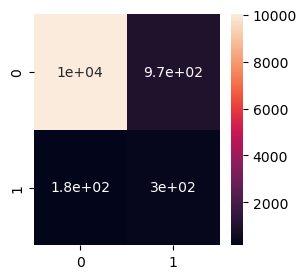

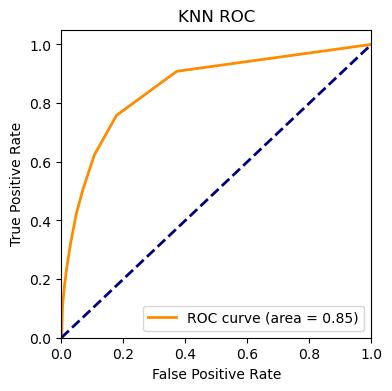

In [9]:
#plot the best values for the knn classifier, confusion matrix and the ROC

plt.figure(figsize=(3,3))
sns.heatmap(conf_matrix_plot(knn_grid,X_test,y_test), annot=True)
plot_roc(knn_grid.best_estimator_,X_test,y_test,'KNN ROC')


# Logistic Regression
### This section fits a logistic regression to the data set.
### The optimization parameters for this model are the penalty term used for the model, the C value.
Scoring of the model is "average_precision" as it works well for mismatched class sizes


In [10]:
#create a logistic regression model to compare to the other
log_pipe = Pipeline([('preprocessor',preprocessor),
                    ('scaler',StandardScaler()),
                    ('log_model',LogisticRegression(max_iter=100))])

log_params = {'log_model__penalty':['l1','l2'], #type of penalty term to apply to model
             'log_model__C':[0.1,1,10,100,1000]} #regularization term, highermeans more overfitting could occr, negated by CV

log_Grid = GridSearchCV(estimator=log_pipe,
                       param_grid=log_params,
                       scoring='average_precision',
                       cv=5)

log_Grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('scaler', StandardScaler()),
                                       ('log_model', LogisticRegression())]),
             param_grid={'log_model__C': [0.1, 1, 10, 100, 1000],
                         'log_model__penalty': ['l1', 'l2']},
             scoring='average_precision')

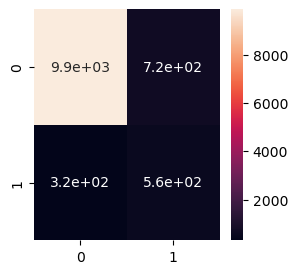

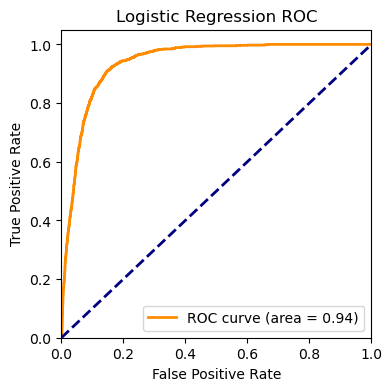

In [11]:
#plot the best estimator results as confusion matrix and roc curve for the logistic regression

plt.figure(figsize=(3,3))
sns.heatmap(conf_matrix_plot(log_Grid,X_test,y_test), annot=True)

#function to plot the roc curve
plot_roc(log_Grid.best_estimator_,X_test,y_test,'Logistic Regression ROC')

# Decision Trees model
### This section uses a decision tree type modelling effort to classify the data sets

In [12]:
#creating a decision tree classifier for the data set
#create pipeline for the decision tree model
dTree_pipe = Pipeline([('preprocess',preprocessor),
                       ('scaler',StandardScaler()),
                       ('model',DecisionTreeClassifier())])

#decision tree paramater grid
dTree_params = {'model__criterion':['gini','entropy','log_loss'], #wualtiy measure, different approaches available need to be tested.
               'model__splitter':['best','random'],
               'model__max_depth':[5,10,15,20], #maximum depth of the model, deeper models could lead to overfitting
               'model__min_samples_split':range(50,1001,50)} #minimu number of sample in a node required to split the node 

dTree_Grid = GridSearchCV(estimator=dTree_pipe,param_grid=dTree_params,scoring='average_precision',cv=5)

dTree_Grid.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('scaler', StandardScaler()),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [5, 10, 15, 20],
                         'model__min_samples_split': range(50, 1001, 50),
                         'model__splitter': ['best', 'random']},
             scoring='average_precision')

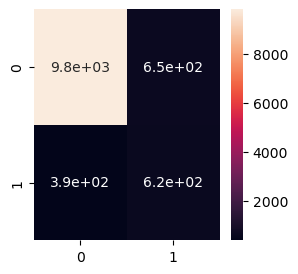

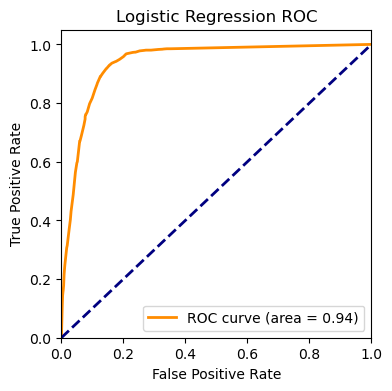

In [13]:
#plot the best estimator results as confusion matrix and roc curve for the logistic regression
plt.figure(figsize=(3,3))
sns.heatmap(conf_matrix_plot(dTree_Grid,X_test,y_test), annot=True)

#function to plot the roc curve
plot_roc(dTree_Grid.best_estimator_,X_test,y_test,'Logistic Regression ROC')

# Section for Support Vector Machine
### This section makes use of a support vector machine type model to classify the data.


In [14]:
#create svm pipeline (take large computational time do=ue to complexity and number of models analyzed)
svm_pipe = Pipeline([('preprocess',preprocessor),
                    ('scaler',StandardScaler()),
                    ('svm',SVC(max_iter=1000,probability=True))])

svm_params = {'svm__C':[0.1,1,10,100],         #regularization term to be used for the data, lower values should help for overfit.
             'svm__kernel':['rbf','linear','sigmoid'], #types of kernel to use, linear will later be necessary for interpretability
             'svm__gamma':['scale','auto'] #two values for Gamma that will give insight into manual tuning for this later.
             }                             

svm_Grid = GridSearchCV(estimator=svm_pipe,param_grid=svm_params,scoring='average_precision',cv=5)

svm_Grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(max_iter=1000, probability=True))]),
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='average_precision')

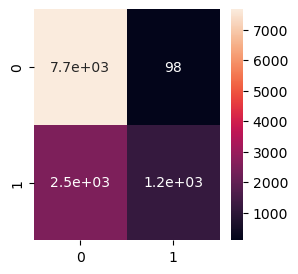

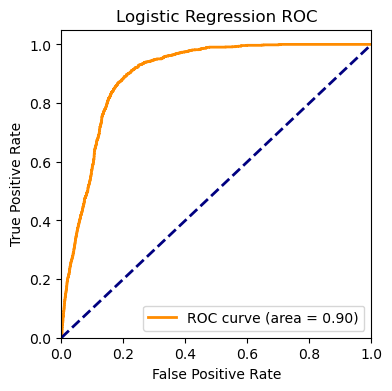

In [15]:
#plot the best estimator results as confusion matrix and roc curve for the logistic regression
plt.figure(figsize=(3,3))
sns.heatmap(conf_matrix_plot(svm_Grid,X_test,y_test), annot=True)

#function to plot the roc curve
plot_roc(svm_Grid.best_estimator_,X_test,y_test,'Logistic Regression ROC')

Text(0.5, 1.0, 'SVC')

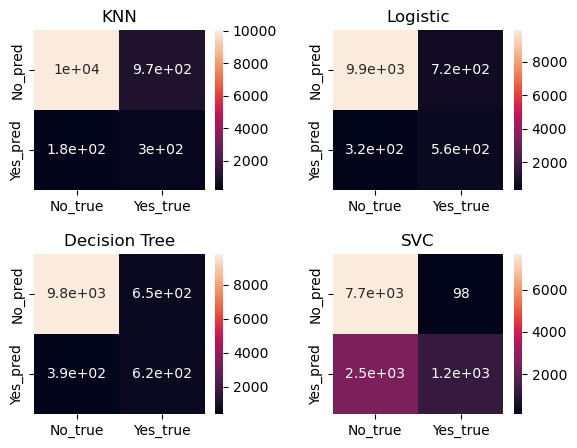

In [16]:
#comparing results of the different models
fig, axs= plt.subplots(2,2)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

sns.heatmap(conf_matrix_plot(knn_grid,X_test,y_test), annot=True,ax=axs[0,0],xticklabels=['No_true','Yes_true'],yticklabels=['No_pred','Yes_pred'])
axs[0,0].set_title('KNN')

sns.heatmap(conf_matrix_plot(log_Grid,X_test,y_test), annot=True,ax=axs[0,1],xticklabels=['No_true','Yes_true'],yticklabels=['No_pred','Yes_pred'])
axs[0,1].set_title('Logistic')

sns.heatmap(conf_matrix_plot(dTree_Grid,X_test,y_test), annot=True,ax=axs[1,0],xticklabels=['No_true','Yes_true'],yticklabels=['No_pred','Yes_pred'])
axs[1,0].set_title('Decision Tree')

sns.heatmap(conf_matrix_plot(svm_Grid,X_test,y_test), annot=True,ax=axs[1,1],xticklabels=['No_true','Yes_true'],yticklabels=['No_pred','Yes_pred'])
axs[1,1].set_title('SVC')

# Initial interpretation of results
From the initial confusion matrices shown, the most applicable model is the SVC classifier. In this case, although computationally expensive this model was able to determine more than %99 of the 'yes' category correctly. No further alterations are therefore required and the feature coefficients can be extracted for their relative importance. In order to determine the feature importance coefficients a linear model will need to be constructed and the coefficients extracted. Although this will not be the exact optimized model, this i a quick way of determining which information to carry over in a non-technical presentation fo findings.

In [18]:
#create svm pipeline
svm_pipe = Pipeline([('preprocess',preprocessor),
                    ('scaler',StandardScaler()),
                    ('svm',SVC(max_iter=200,probability=True))])

svm_params = {'svm__C':[0.1,1,10,100],         #regularization term to be used for the data, lower values should help for overfit.
             'svm__kernel':['linear'], #types of kernel to use, linear will later be necessary for interpretability
             'svm__gamma':['auto'] #two values for Gamma that will give insight into manual tuning for this later.
             }                             

svm_Grid = GridSearchCV(estimator=svm_pipe,param_grid=svm_params,scoring='average_precision',cv=5)

svm_Grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('scaler', StandardScaler()),
                                       ('svm',
                                        SVC(max_iter=200, probability=True))]),
             param_grid={'svm__C': [0.1, 1, 10, 100], 'svm__gamma': ['auto'],
                         'svm__kernel': ['linear']},
             scoring='average_precision')

In [31]:
best_linear_SVM = svm_Grid.best_estimator_
svm_Model = best_linear_SVM.named_steps['svm'].coef_

svm_pipe.fit(X_train,y_train)
feature_names = svm_pipe.named_steps['preprocess'].get_feature_names_out(
    input_features=X_train.columns)

In [76]:
#ensuring the feature names are correctly displayed 
#print(svm_Model)
#print(feature_names)

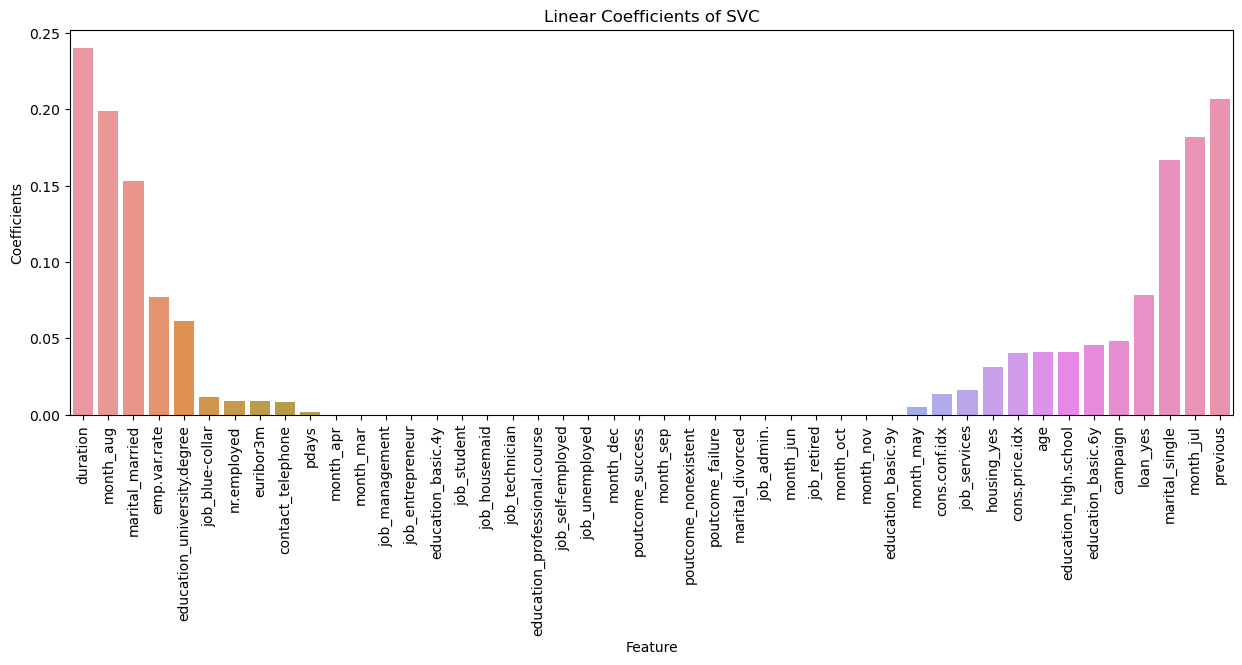

In [62]:
#creating initial plot to determine the importance of the various features
coef_Data = pd.DataFrame({'Feature': feature_names,'Coefficients':svm_Model[0]})

#trimming the string values 
coef_Data['Feature'] = coef_Data['Feature'].str.replace('one_hot__',"").str.replace('remainder__',"")

#sort the coefficients by importance
coef_Data = coef_Data.sort_values(by='Coefficients',ascending=False)
coef_Data_abs =coef_Data
coef_Data_abs['Coefficients'] = coef_Data_abs['Coefficients'].abs()
coef_Data_abs = coef_Data_abs.sort_values(by='Coefficients',ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=coef_Data,x='Feature',y='Coefficients')
plt.title('Linear Coefficients of SVC')
plt.xticks(rotation=90)
plt.show()

# Evaluation of model:
The best model for this business outcome was the SVC type model. The results had the largest false positives of any class however since the goal is to do targetted marketting where a missed opportunity is non-beneficial it is better to have more false positives than false negative values. For the best fit SVC only 98 "yes" values were labelled as false negative. Although 25e+10 were false positive this still reduces the target market by more than %50 which equates to a drastic reduction in phone calls required and time spent on concretely true negative values. 
Upon further analysis of the secondary linear svc model that was fit the coefficients yield insight into who to market for with the following conclusions being drawn from the graph above.
1. The duration of the phone call is the largest indicator of success, this means that further analysis may be required in order to determine which individual stay on the phone longer.
2. with regards to months, most months do not have a large impact on the outcome, however it is noticeable that the month of august had a positive impact, while the month of july had a largely negative impact. This behaviour could be driven by social factors such as vacation times, or other factors such as the end of tax season in portugal and when people recieve their tax returns.
3. With regareds to education level, people with higher education levels had larger chance of a positive outcome. People with only 6 years of education being negatively influenced to creating a nother bank account, followed closely by those with only a high school level of education. Potentially explaining in simpler terms to these individuals how they would benefit from the new accounts would be useful if correctly applied.
4. Married individuals showed the highest chance of positive outcome of all marital statuses while single people were negatively inclined to getting a new bank account.
5. job type had minimal impact on whether people wanted to get loans or not.
6. People with loans are negatively prone to creating a new bank account, potentially due to lack of liquid funds.
7. People who had been previously contacted were negatively inclined to getting another bank account. This being the single largest negative factor in this model.
8. The number of times the telemarketter reached out to an individual had a slight negative effect on outcome, this would mean that the telemarketters should aim to make a sale on the first time reaching out to a potential customer.